In [199]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math

In [200]:
df = pd.read_csv('mock_kaggle.csv')
df = df.rename(columns={'data': 'date','venda': 'sold', 'estoque': 'stock', 'preco': 'price'})

In [201]:
df

,date,sold,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [202]:
df = df[(df != 0).all(1)]
df

,date,sold,stock,price
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
5,2014-01-06,145,4509,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


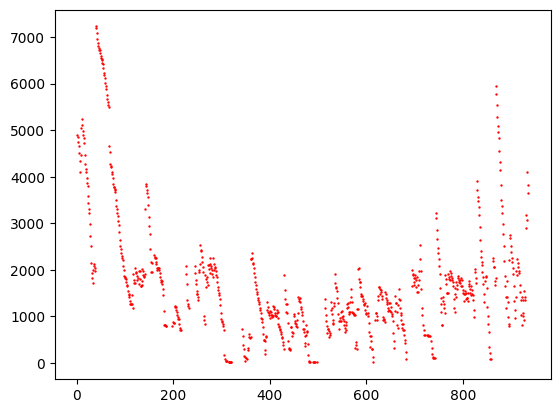

In [203]:
x_stock = df.index
y_stock = df.stock

plt.scatter(x_stock, y_stock, s=0.5, color='red')

/home/oleg/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


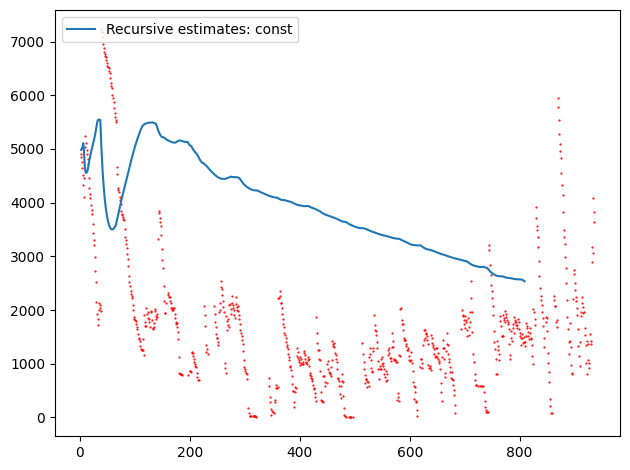

In [204]:
endog_sold = y_stock
exog_sold = sm.add_constant(x_stock)

model_sold = sm.RecursiveLS(endog_sold, exog_sold)
res_sold = model_sold.fit()

res_sold.plot_recursive_coefficient(alpha=None)

res_sold_coefs = res_sold.recursive_coefficients.filtered[0]

plt.scatter(x_stock, y_stock, s=0.3, color='red')

In [205]:
def calculate_square_deviation(y_real, y_predict):
    deviation = 0
    for i in range(len(y_real)):
        dev = y_real[i] - y_predict[i]
        deviation += dev**2
    return deviation

In [206]:
def coefficients_calculation(x_values, y_values):
    average_x = 0
    average_y = 0
    average_xy = 0
    average_xx = 0
    n = len(x_values)
    for i in range(n):
        average_x += x_values[i]
        average_y += y_values[i]
        average_xy += x_values[i]*y_values[i]
        average_xx += x_values[i]**2
    average_x = average_x/n
    average_y = average_y/n
    average_xy = average_xy/n
    average_xx = average_xx/n
    d_x = average_xx - average_x**2
    b = (average_xy - average_x*average_y)/d_x
    a = average_y - b * average_x
    return (a, b)

In [207]:
linearization_funcs_data = pd.DataFrame(columns=['Linearization_func_name', 'square_deviation'])
linearization_funcs_data

,Linearization_func_name,square_deviation


Линейная y = a+b*x

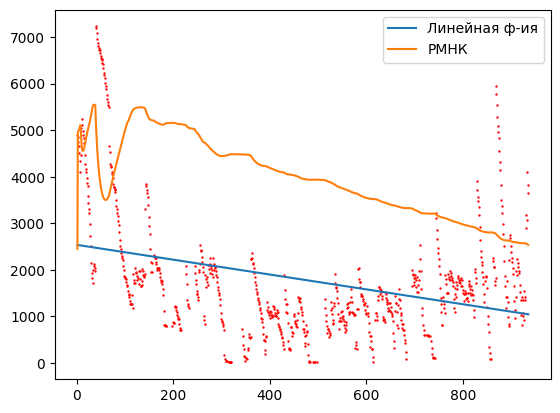

In [208]:
def graph(x_vals, y_vals):
    a,b = coefficients_calculation(x_vals, y_vals)
    
    def y_final_formula(x):
        return a  + b * x
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)

    new_data = {'Linearization_func_name': 'Линейная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    plt.plot(x_vals, final_y, label='Линейная ф-ия')  

    return x_vals, final_y


x_linear, y_linear = graph(list(x_stock), list(y_stock))

plt.plot( list(x_stock), res_sold_coefs, label='РМНК')
plt.scatter(x_stock, y_stock, s=0.5, color='red')

plt.legend()


Гиперболическая y = a + b/x 

transform to y = a + b * t where t = 1/x ; for lsm: a = c , b = d

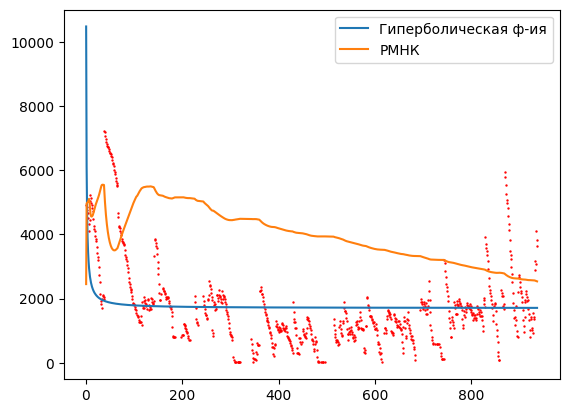

In [209]:
def graph(x_vals, y_vals):
    def y_transform_to_g(y):
        return y

    def x_transform_to_t(x):
        return 1 / x


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = c
    d_to_b = d


    def y_final_formula(x):
        return c_to_a + d_to_b / x
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))


    square_dev = calculate_square_deviation(list(y_vals), final_y)

    new_data = {'Linearization_func_name': 'Гиперболическая', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    plt.plot(x_vals, final_y, label='Гиперболическая ф-ия') 
    return x_vals, final_y 


x_hyperbolic, y_hyperbolic = graph(x_stock, y_stock)
plt.scatter(x_stock, y_stock, s=0.5, color='red')


plt.plot( list(x_stock), res_sold_coefs, label='РМНК')
plt.legend()

Логарифмическая y = a + b * ln(x)

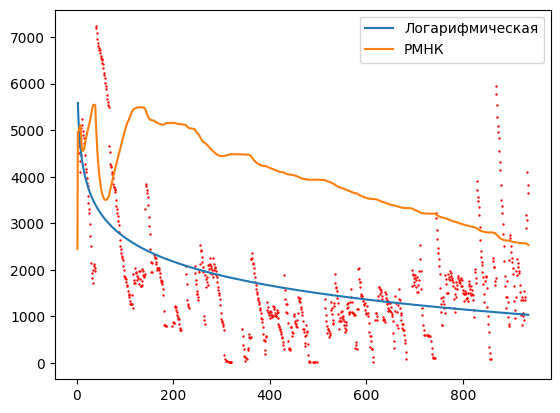

In [210]:
def graph(x_vals, y_vals):
    def y_transform_to_g(y):
        return y

    def x_transform_to_t(x):
        return math.log(x, math.e)


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = c
    d_to_b = d


    def y_final_formula(x):
        return c_to_a + d_to_b * math.log(x, math.e)
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Логарифмическая', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data


    plt.plot(x_vals, final_y, label='Логарифмическая')
    return x_vals, final_y


x_log, y_log = graph(x_stock[1:], y_stock[1:])
plt.scatter(x_stock[1:], y_stock[1:], s=0.5, color='red')


plt.plot( list(x_stock), res_sold_coefs, label='РМНК')
plt.legend()

Показательная y = a * e ^ (b*x)

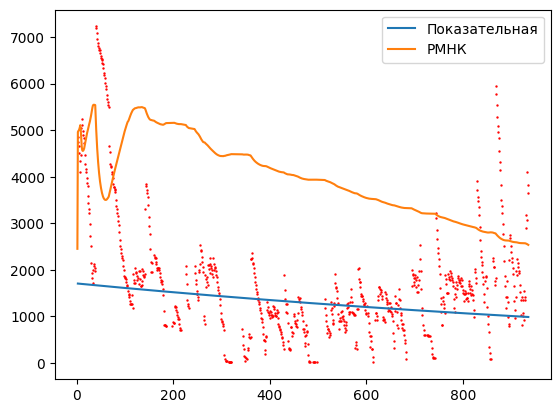

In [211]:
def graph(x_vals, y_vals):  
    def y_transform_to_g(y):
        return math.log(y, math.e)

    def x_transform_to_t(x):
        return x


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = math.e**c
    d_to_b = d

    def y_final_formula(x):
        return c_to_a * math.e ** (d_to_b * x)
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Показательная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    plt.plot(x_vals, final_y, label='Показательная')
    return x_vals, final_y


x_pokazatelnaya, y_pokazatelnaya = graph(x_stock[1:], y_stock[1:])
plt.scatter(x_stock[1:], y_stock[1:], s=0.5, color='red')


plt.plot( list(x_stock), res_sold_coefs, label='РМНК')
plt.legend()

Степенная y = a * x ^ b

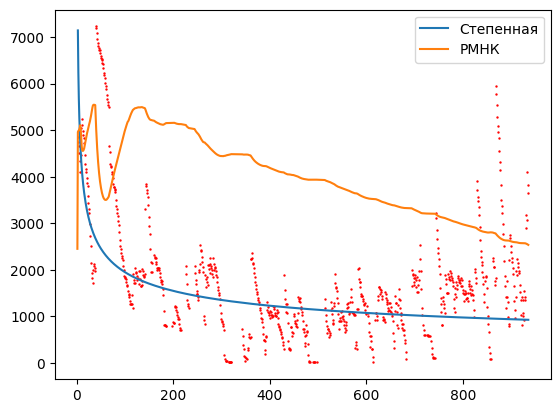

In [212]:
def graph(x_vals, y_vals):  
    def y_transform_to_g(y):
        return math.log(y, math.e)

    def x_transform_to_t(x):
        return math.log(x, math.e)


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = math.e**c
    d_to_b = d

    def y_final_formula(x):
        return c_to_a * x ** d_to_b
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Степенная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    
    plt.plot(x_vals, final_y, label='Степенная')
    return x_vals, final_y

x_steppenaya, y_steppenaya = graph(x_stock[1:], y_stock[1:])
plt.scatter(x_stock[1:], y_stock[1:], s=0.5, color='red')


plt.plot( list(x_stock), res_sold_coefs, label='РМНК')
plt.legend()

Комбинированная y = 1 / (a+b*e^(-x))

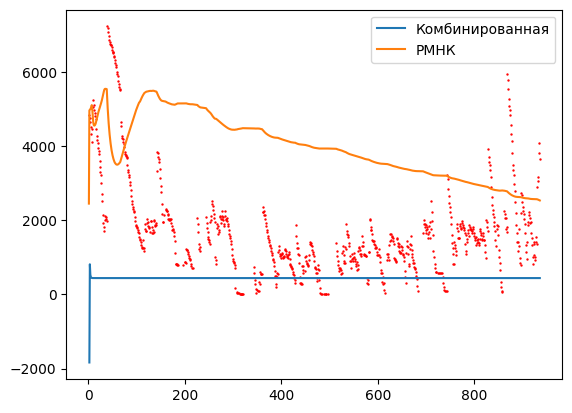

In [213]:
def graph(x_vals, y_vals):  
    def y_transform_to_g(y):
        return 1/y

    def x_transform_to_t(x):
        return math.e ** (-x)


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = c
    d_to_b = d

    def y_final_formula(x):
        return 1 / (c_to_a + d_to_b * math.e ** (-x))
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Комбинированная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    
    plt.plot(x_vals, final_y, label='Комбинированная')
    return x_vals, final_y

x_comb, y_comb = graph(x_stock[1:], y_stock[1:])
plt.scatter(x_stock[1:], y_stock[1:], s=0.5, color='red')


plt.plot( list(x_stock), res_sold_coefs, label='РМНК')
plt.legend()

In [214]:
square_dev = calculate_square_deviation(list(y_stock[1:]), res_sold_coefs)
    
new_data = {'Linearization_func_name': 'РМНК', 'square_deviation': square_dev}
linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data


In [215]:
linearization_funcs_data

,Linearization_func_name,square_deviation
0,Линейная,1.318219e+09
1,Гиперболическая,1.356492e+09
2,Логарифмическая,1.007979e+09
3,Показательная,1.507799e+09
4,Степенная,1.120139e+09
5,Комбинированная,2.921763e+09
6,РМНК,5.657543e+09


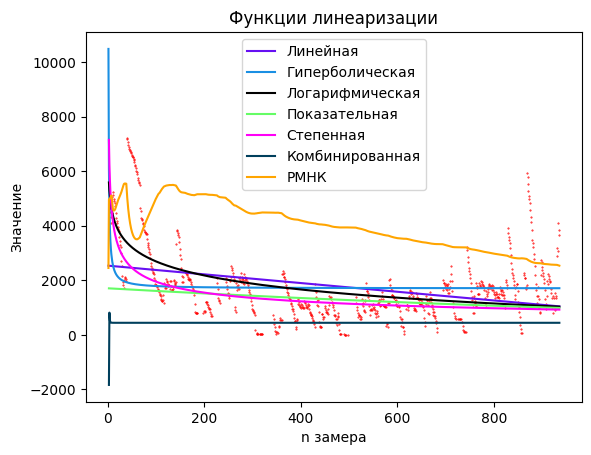

In [216]:
plt.plot(x_linear, y_linear, '#6610F2', label="Линейная") # plotting t, a separately 
plt.plot(x_hyperbolic, y_hyperbolic, '#1A8FE3', label="Гиперболическая") # plotting t, b separately 
plt.plot(x_log, y_log, 'black', label="Логарифмическая") # plotting t, c separately 
plt.plot(x_pokazatelnaya, y_pokazatelnaya, '#65FC65', label="Показательная") # plotting t, c separately 
plt.plot(x_steppenaya, y_steppenaya, '#FF00F7', label="Степенная") # plotting t, c separately 
plt.plot(x_comb, y_comb, '#003f5c', label="Комбинированная") # plotting t, c separately 

plt.plot( list(x_stock), res_sold_coefs, 'orange', label='РМНК')

plt.title("Функции линеаризации")
plt.xlabel("n замера")
plt.ylabel("Значение")
plt.legend()

plt.scatter(x_stock[1:], y_stock[1:], s=0.2, color='red')


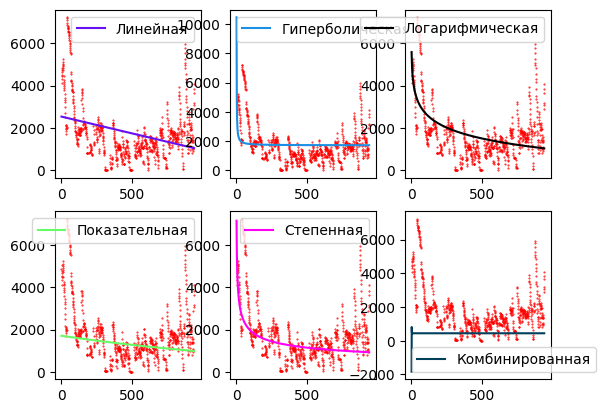

In [217]:
figure, axis = plt.subplots(2, 3) 


axis[0,0].plot(x_linear, y_linear, '#6610F2', label="Линейная") # plotting t, a separately 
axis[0,0].scatter(x_stock[1:], y_stock[1:], s=0.2, color='red')
axis[0,0].legend()

axis[0,1].plot(x_hyperbolic, y_hyperbolic, '#1A8FE3', label="Гиперболическая") # plotting t, b separately 
axis[0,1].scatter(x_stock[1:], y_stock[1:], s=0.2, color='red')
axis[0,1].legend()

axis[0,2].plot(x_log, y_log, 'black', label="Логарифмическая") # plotting t, c separately 
axis[0,2].scatter(x_stock[1:], y_stock[1:], s=0.2, color='red')
axis[0,2].legend()

axis[1,0].plot(x_pokazatelnaya, y_pokazatelnaya, '#65FC65', label="Показательная") # plotting t, c separately 
axis[1,0].scatter(x_stock[1:], y_stock[1:], s=0.2, color='red')
axis[1,0].legend()

axis[1,1].plot(x_steppenaya, y_steppenaya, '#FF00F7', label="Степенная") # plotting t, c separately 
axis[1,1].scatter(x_stock[1:], y_stock[1:], s=0.2, color='red')
axis[1,1].legend()

axis[1,2].plot(x_comb, y_comb, '#003f5c', label="Комбинированная") # plotting t, c separately 
axis[1,2].scatter(x_stock[1:], y_stock[1:], s=0.2, color='red')
axis[1,2].legend()